# Feature Extraction and Selection

This basic example shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to extract useful features from multiple timeseries and use them to improve regression performance.

We use the robot execution failure data set as an example.

In [11]:
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load and visualize data

The data set documents 88 robot executions (each has a unique `id` between 1 and 88), which is a subset of the [Robot Execution Failures Data Set](https://archive.ics.uci.edu/ml/datasets/Robot+Execution+Failures). 
For the purpose of simplicity we are only differentiating between successfull and failed executions (`y`).

For each execution 15 force (F) and torque (T) samples are given, which were measured at regular time intervals for the spatial dimensions x, y, and z. 
Therefore each row of the data frame references a specific execution (`id`), a time index (`index`) and documents the respective measurements of 6 sensors (`F_x`, `F_y`, `F_z`, `T_x`, `T_y`, `T_z`).

In [42]:
import math
import numpy as np
import pandas as pd

# x
def id(x):
    return x

# x^2
def sq(x):
    return x**2

# exp(x/2)
def exp(x):
    return math.exp(x/2)

# 1 + sin(x)
def trig(x):
    return 1 + math.sin(x)

def err():
    return np.random.normal()/10

def load_data(length, seed=None):
    if seed is not None:
        np.seed(seed)

    x = list(range(length))
    
    df = []
    y = []
    i = 0
    for f in [id, trig]:
        for x_0 in x:
            value = f(x_0) * (1 + err())
            df.append([i, x_0, value])
        i += 1
        y.append(f(length))

    df = pd.DataFrame(df, columns=['id', 'time', 'value'])
    y = pd.Series(y)
    
    return df, y
    


df, y = load_data(10)

# y = df.loc[df.time >= 0.5, ['id', 'value']].set_index('id')

# y
df

,id,time,value
0,0,0,0.000000
1,0,1,1.025851
2,0,2,2.369388
3,0,3,2.860794
4,0,4,3.669955
5,0,5,4.744706
6,0,6,6.311846
7,0,7,7.421734
8,0,8,6.746803
9,0,9,8.224491


In [43]:
y

0    10.000000
1     0.455979
dtype: float64

Let's draw some example executions:

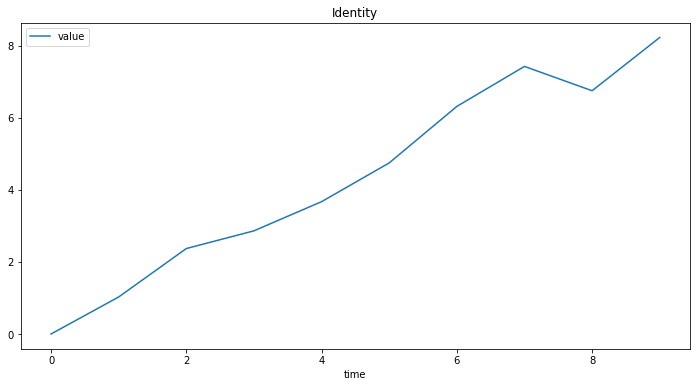

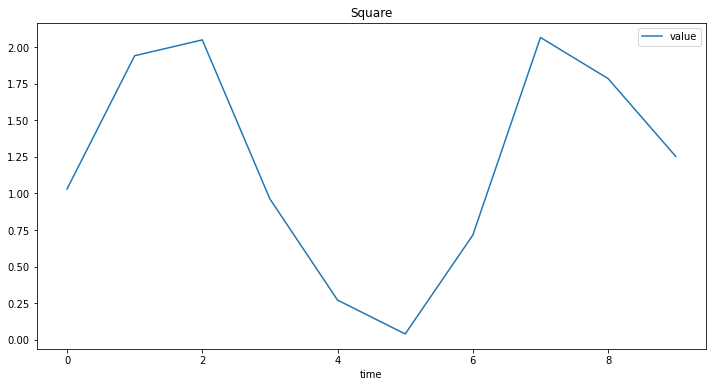

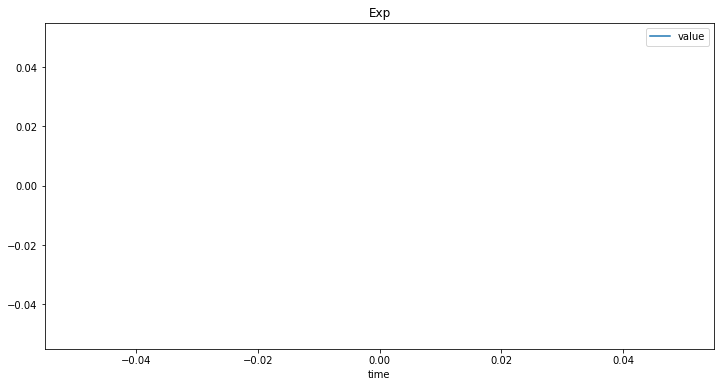

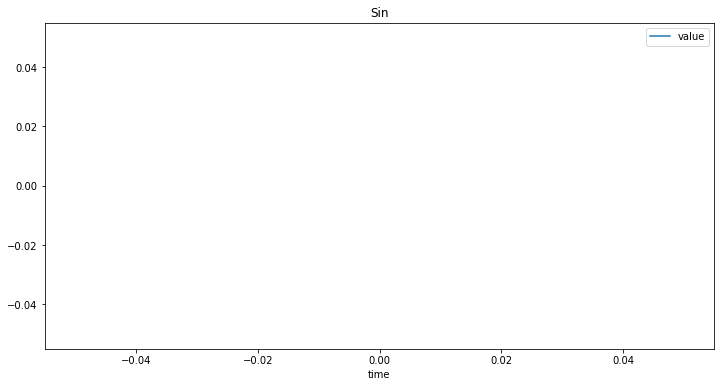

In [44]:
df[df.id == 0][['time', 'value']].plot(x='time', title='Identity', figsize=(12, 6));
df[df.id == 1][['time', 'value']].plot(x='time', title='Square', figsize=(12, 6));
df[df.id == 2][['time', 'value']].plot(x='time', title='Exp', figsize=(12, 6));
df[df.id == 3][['time', 'value']].plot(x='time', title='Sin', figsize=(12, 6));

## Extract Features

We can use the data to extract time series features using `tsfresh`.
We want to extract features for each time series, that means for each robot execution (which is our `id`) and for each of the measured sensor values (`F_*` and `T_*`).

You can think of it like this: tsfresh will result in a single row for each `id` and will calculate the features for each columns (we call them "kind") separately.

The `time` column is our sorting column.
For an overview on the data formats of `tsfresh`, please have a look at [the documentation](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

In [45]:
# We are very explicit here and specify the `default_fc_parameters`. If you remove this argument,
# the ComprehensiveFCParameters (= all feature calculators) will also be used as default.
# Have a look into the documentation (https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)
# or one of the other notebooks to learn more about this.
extraction_settings = ComprehensiveFCParameters()

X = extract_features(df, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.74it/s]


`X` now contains for each robot execution (= `id`) a single row, with all the features `tsfresh` calculated based on the measured times series values for this `id`.

In [46]:
X

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,43.375569,258.914461,1.063817,0.913832,0.028240,4.207331,...,0.950271,1.039721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.711476
1,0.0,0.0,0.0,0.0,12.111322,19.555990,0.651618,0.024784,-0.090109,1.141510,...,1.609438,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.583444


<div class="alert alert-info">

Currently, 4674 non-NaN features are calculated. 
This number varies with the version of `tsfresh` and with your data.
    
</div>

## Select Features

Using the hypothesis tests implemented in `tsfresh` (see [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html) for more information) it is now possible to select only the relevant features out of this large dataset.

`tsfresh` will do a hypothesis test for each of the features to check, if it is relevant for your given target.

In [47]:
X_filtered = select_features(X, y)

In [48]:
X_filtered

""
0
1


<div class="alert alert-info">

Currently, 669 non-NaN features survive the feature selection given this target.
Again, this number will vary depending on your data, your target and the `tsfresh` version.
    
</div>

## Train and evaluate classifier

Let's train a boosted decision tree on the filtered as well as the full set of extracted features.

In [58]:
X_full_train, X_full_test, y_train, y_test = train_test_split(X, y, test_size=.4)
X_filtered_train, X_filtered_test = X_full_train[X_filtered.columns], X_full_test[X_filtered.columns]

In [59]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_full_train, y_train)
y_pred = classifier_full.predict(X_full_test)

print(classification_report(y_test, y_pred))

ValueError: Unknown label type: 'continuous'

In [26]:
classifier_filtered = DecisionTreeClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
y_pred_filtered = classifier_filtered.predict(X_filtered_test)

print(classification_report(y_test, y_pred_filtered))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        23
        True       0.93      1.00      0.96        13

    accuracy                           0.97        36
   macro avg       0.96      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



Compared to using all features (`classifier_full`), using only the relevant features (`classifier_filtered`) achieves better classification performance with less data.

<div class="alert alert-info">

Please remember that the hypothesis test in `tsfresh` is a statistical test.
You might get better performance with other feature selection methods (e.g. training a classifier with
all but one feature to find its importance) - but in general the feature selection implemented
in `tsfresh` will give you a very reasonable set of selected features.
    
</div>

## Extraction and Filtering is the same as filtered Extraction

Above, we performed the feature extraction and selection independently. 
If you are only interested in the list of selected features, you can run this in one step:

In [9]:
X_filtered_2 = extract_relevant_features(df, y, column_id='id', column_sort='x',
                                         default_fc_parameters=extraction_settings)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.42it/s]


In [10]:
(X_filtered.columns == X_filtered_2.columns).all()

True